In [140]:
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_squared_error, roc_curve, auc
import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd
import shap
from keras.layers import Input, Dense, Flatten, \
    Concatenate, concatenate, Dropout, Lambda
from keras.models import Model, Sequential
from keras.layers.embeddings import Embedding
import keras
from livelossplot import PlotLossesKeras
import math


shap.initjs()



# Census income classification with Keras

We use keras to perform this computation


In [152]:
label_column = "loan"
csv_path = 'data/adult.data'
csv_columns = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
                   "occupation", "relationship", "ethnicity", "gender", "capital-gain", "capital-loss",
                   "hours-per-week", "native-country", "loan"]
input_columns = ["age", "workclass", "education", "education-num", "marital-status",
                   "occupation", "relationship", "ethnicity", "gender", "capital-gain", "capital-loss",
                   "hours-per-week", "native-country"]
categorical_features = ["workclass", "education", "marital-status",
                       "occupation", "relationship", "ethnicity", "gender",
                       "native-country"]

In [153]:
df = pd.read_csv(csv_path, names=csv_columns)
df[label_column] = df[label_column].apply(lambda x: ">50K" in x)
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,ethnicity,gender,capital-gain,capital-loss,hours-per-week,native-country,loan
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,False
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,False
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,False
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,False
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,False


In [154]:
def prepare_data(df):
    
    X = df.drop(label_column, axis=1).copy()
    y = df[label_column].astype(int).values.copy()

    # normalize data (this is important for model convergence)
    dtypes = list(zip(X.dtypes.index, map(str, X.dtypes)))
    for k,dtype in dtypes:
        if dtype == "int64":
            X[k] = X[k].astype(np.float32)
            X[k] -= X[k].mean()
            X[k] /= X[k].std()

    cat_columns = X.select_dtypes(['object']).columns
    X[cat_columns] = X[cat_columns].astype('category')
    X[cat_columns] = X[cat_columns].apply(lambda x: x.cat.codes)
    X[cat_columns] = X[cat_columns].astype('int8')
    
    # Rerun dtypes with the new columns
    dtypes = list(zip(X.dtypes.index, map(str, X.dtypes)))
    
    return X, y, dtypes

In [155]:
if "fnlwgt" in df: del df["fnlwgt"]

X_display = df.drop(label_column, axis=1).copy()
y_display = df[label_column].astype(int).values.copy()

X, y, dtypes = prepare_data(df)

X_train, X_valid, y_train, y_valid = \
    train_test_split(X, y, test_size=0.2, random_state=7)

X.head(5)


,age,workclass,education,education-num,marital-status,occupation,relationship,ethnicity,gender,capital-gain,capital-loss,hours-per-week,native-country
0,0.030670,7,9,1.134721,4,1,1,4,1,0.148451,-0.216656,-0.035429,39
1,0.837096,6,9,1.134721,2,4,0,4,1,-0.145918,-0.216656,-2.222119,39
2,-0.042641,4,11,-0.420053,0,6,1,4,1,-0.145918,-0.216656,-0.035429,39
3,1.057031,4,1,-1.197440,2,6,0,2,1,-0.145918,-0.216656,-0.035429,39
4,-0.775756,4,9,1.134721,2,10,5,2,0,-0.145918,-0.216656,-0.035429,5


In [156]:
def build_model():
    input_els = []
    encoded_els = []
    for k,dtype in dtypes:
        input_els.append(Input(shape=(1,)))
        if dtype == "int8":
            e = Flatten()(Embedding(X_train[k].max()+1, 1)(input_els[-1]))
        else:
            e = input_els[-1]
        encoded_els.append(e)
    encoded_els = concatenate(encoded_els)

    layer1 = Dropout(0.5)(Dense(100, activation="relu")(encoded_els))
    out = Dense(1, activation='sigmoid')(layer1)

    # train model
    model = Model(inputs=input_els, outputs=[out])
    model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])
    return model

def f_in(X, m=None):
    """Preprocess input so it can be provided to a function"""
    if m:
        return [X.iloc[:m,i] for i in range(X.shape[1])]
    else:
        return [X.iloc[:,i] for i in range(X.shape[1])]

def f_out(probs):
    """Convert probabilities into classes"""
    return list((probs >= 0.5).astype(int).T[0])

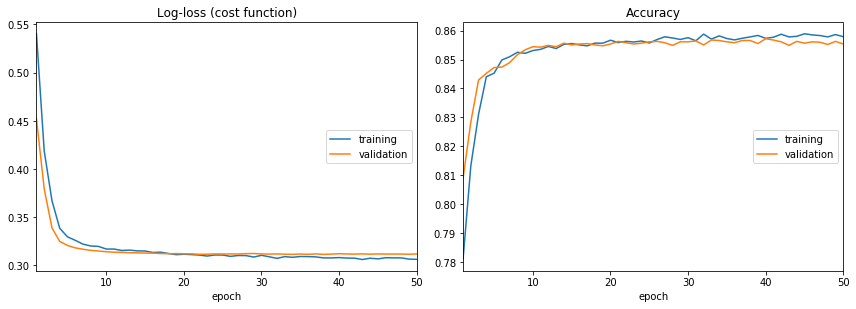

Log-loss (cost function):
training   (min:    0.306, max:    0.540, cur:    0.306)
validation (min:    0.311, max:    0.452, cur:    0.312)

Accuracy:
training   (min:    0.781, max:    0.859, cur:    0.858)
validation (min:    0.809, max:    0.857, cur:    0.855)


In [157]:
model = build_model()

model.fit(
    f_in(X_train),
    y_train,
    epochs=50,
    batch_size=512,
    shuffle=True,
    validation_data=(f_in(X_valid), y_valid),
    callbacks=[PlotLossesKeras()],
    verbose=0,
    validation_split=0.05,
)

In [130]:
score = model.evaluate(f_in(X_valid), y_valid, verbose=1)
print(score)

6513/6513 [==============================] - 0s 17us/step
[1.201090527353209, 0.7620144327005702]


In [131]:
probabilities = model.predict(f_in(X_valid))
print(list(probabilities.T[0])[:10])

[0.0005854317, 0.004467436, 0.00042640598, 8.517575e-06, 0.00041670914, 0.00082164886, 0.00020724307, 0.0022653122, 2.6999587e-06, 0.028074717]


In [132]:
pred = f_out(probabilities)
print(pred[:10])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [133]:
print(sklearn.metrics.classification_report(y_valid, pred))

print("\nF1 Score:", sklearn.metrics.f1_score(y_valid, pred))

print("\nAccuracy:", sklearn.metrics.accuracy_score(y_valid, pred))

              precision    recall  f1-score   support

           0       0.76      1.00      0.86      4951
           1       1.00      0.01      0.02      1562

   micro avg       0.76      0.76      0.76      6513
   macro avg       0.88      0.50      0.44      6513
weighted avg       0.82      0.76      0.66      6513


F1 Score: 0.015247776365946633

Accuracy: 0.7620144326731153


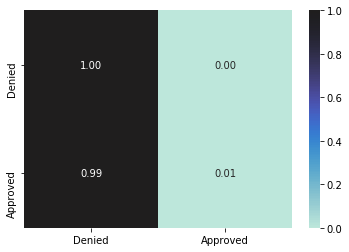

In [134]:
confusion = sklearn.metrics.confusion_matrix(y_valid, pred)

confusion_scaled = \
    confusion.astype("float") / confusion.sum(axis=1)[:, np.newaxis]

confusion_scaled_df = pd.DataFrame(confusion_scaled, 
            index=["Denied", "Approved"], 
            columns=["Denied", "Approved"])

sn.heatmap(confusion_scaled_df, annot=True, fmt='.2f', center=1)
plt.show()

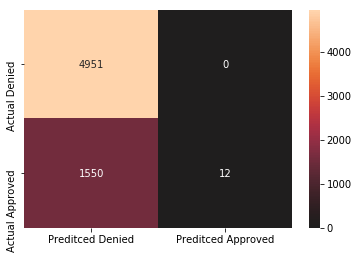

In [135]:
confusion_df = pd.DataFrame(confusion,
            index=["Actual Denied", "Actual Approved"], 
            columns=["Preditced Denied", "Preditced Approved"])

sn.heatmap(confusion_df, annot=True, fmt='d', center=1)
plt.show()

In [139]:
def plot_roc(y, probs):
    fpr, tpr, _ = roc_curve(y, probs)

    roc_auc = auc(fpr, tpr)
    print(roc_auc)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()
??roc_curve

0.5038412291933418


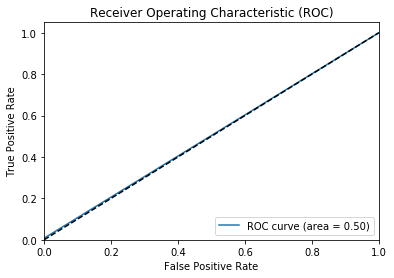

In [138]:
plot_roc(y_valid, pred)

# Learning curves

In [45]:
def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errors, val_errors = [], []
    for m in list(np.logspace(0.6,4,dtype='int')):
        if m >= len(X_train): break
        model.fit(f_in(X_train,m), y_train[:m], epochs=50, batch_size=512, verbose=0)
        y_train_predict = model.predict(f_in(X_train,m))
        y_val_predict = model.predict(f_in(X_val))
        y_train_predict = f_out(y_train_predict)
        y_val_predict = f_out(y_val_predict)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")


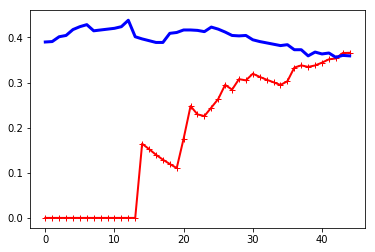

In [105]:
plot_learning_curves(model, X_valid, y_valid)

# SHAP for TF/Keras

In [29]:
def shap_predict(X):
    values = model.predict([X[:,i] for i in range(X.shape[1])]).flatten()
    return values

shap_explainer = shap.KernelExplainer(shap_predict, X.iloc[:100,:])

In [30]:
shap_idx = 0
shap_x = X.iloc[shap_idx,:]
shap_display_x = X_display.iloc[shap_idx,:]
shap_values = shap_explainer.shap_values(shap_x, nsamples=500)

In [31]:

print("Probability: ", probabilities[shap_idx])
shap.force_plot(shap_explainer.expected_value, shap_values, shap_display_x)

Probability:  [0.0936505]


In [32]:
shap_idx_multi_from = 15
shap_idx_multi_to = 40

In [33]:
shap_x_multi = X.iloc[shap_idx_multi_from:shap_idx_multi_to,:]
shap_display_multi = X_display.iloc[shap_idx_multi_from:shap_idx_multi_to,:]
shap_y_multi = y[shap_idx_multi_from:shap_idx_multi_to]

In [34]:
shap_values_multi = shap_explainer.shap_values(shap_x_multi, nsamples=500)

100%|██████████| 25/25 [00:18<00:00,  1.39it/s]


In [35]:
shap.force_plot(shap_explainer.expected_value, shap_values_multi, shap_display_multi)


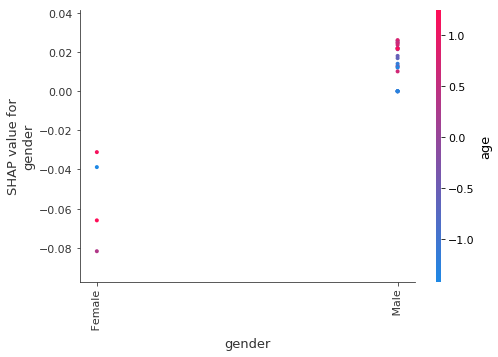

In [36]:
shap.dependence_plot("gender", 
                     shap_values_multi, 
                     shap_x_multi, 
                     display_features=shap_display_multi)

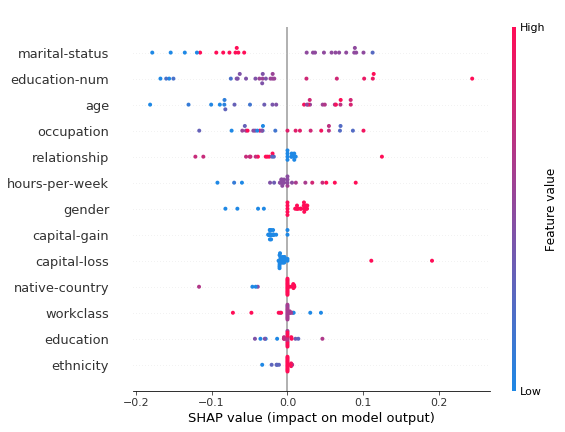

In [37]:
shap.summary_plot(shap_values_multi, shap_x_multi)

In [55]:
cat_columns = X.select_dtypes(['int8']).columns
disp_cols = X_display[cat_columns].astype('category')
for col_name in cat_columns:
    print("\n\n", col_name)
    disp_col = disp_cols[col_name]
    for d,c in enumerate(disp_col.cat.categories):
        print(d,c)



 workclass
0  ?
1  Federal-gov
2  Local-gov
3  Never-worked
4  Private
5  Self-emp-inc
6  Self-emp-not-inc
7  State-gov
8  Without-pay


 education
0  10th
1  11th
2  12th
3  1st-4th
4  5th-6th
5  7th-8th
6  9th
7  Assoc-acdm
8  Assoc-voc
9  Bachelors
10  Doctorate
11  HS-grad
12  Masters
13  Preschool
14  Prof-school
15  Some-college


 marital-status
0  Divorced
1  Married-AF-spouse
2  Married-civ-spouse
3  Married-spouse-absent
4  Never-married
5  Separated
6  Widowed


 occupation
0  ?
1  Adm-clerical
2  Armed-Forces
3  Craft-repair
4  Exec-managerial
5  Farming-fishing
6  Handlers-cleaners
7  Machine-op-inspct
8  Other-service
9  Priv-house-serv
10  Prof-specialty
11  Protective-serv
12  Sales
13  Tech-support
14  Transport-moving


 relationship
0  Husband
1  Not-in-family
2  Other-relative
3  Own-child
4  Unmarried
5  Wife


 ethnicity
0  Amer-Indian-Eskimo
1  Asian-Pac-Islander
2  Black
3  Other
4  White


 gender
0  Female
1  Male


 native-country
0  ?
1  Cambodia
2  Canada

# LIME on Keras+Tensorflow

In [56]:
from lime.lime_tabular import LimeTabularExplainer

In [57]:
tf_lime_explainer = LimeTabularExplainer(
                X_train.values,
                feature_names=list(X_train.columns),
                categorical_features=categorical_features)

In [58]:
def lime_predict_proba(X):
    values = model.predict([X[:,i] for i in range(X.shape[1])]).flatten()
    prob_pairs = np.array([1-values, values]).T
    return prob_pairs

tf_lime_explanation = tf_lime_explainer.explain_instance(
        X_train.iloc[1,:], lime_predict_proba, num_features=13) 

/home/alejandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.947930e-27
  overwrite_a=True).T


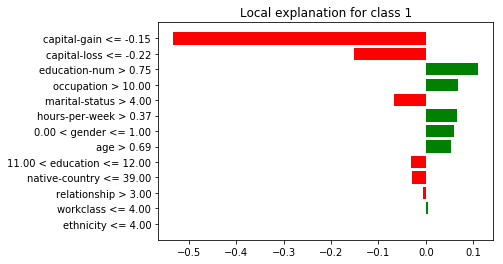

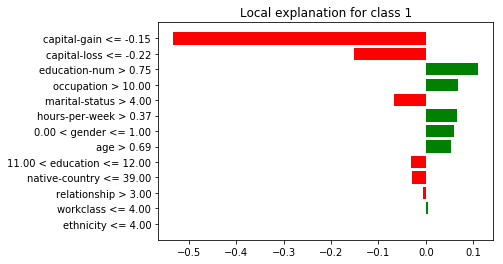

In [61]:
tf_lime_explanation.as_pyplot_figure()

In [62]:
tf_lime_explanation.show_in_notebook(show_table=True, show_all=True)

# Data Analysis

In [63]:
X_analysis = X_display.copy()
y_analysis = y_display.copy()
df_analysis = X_analysis.copy()
df_analysis[label_column] = y_analysis

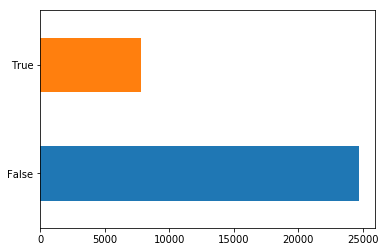

In [65]:
df[label_column].value_counts().plot.barh()

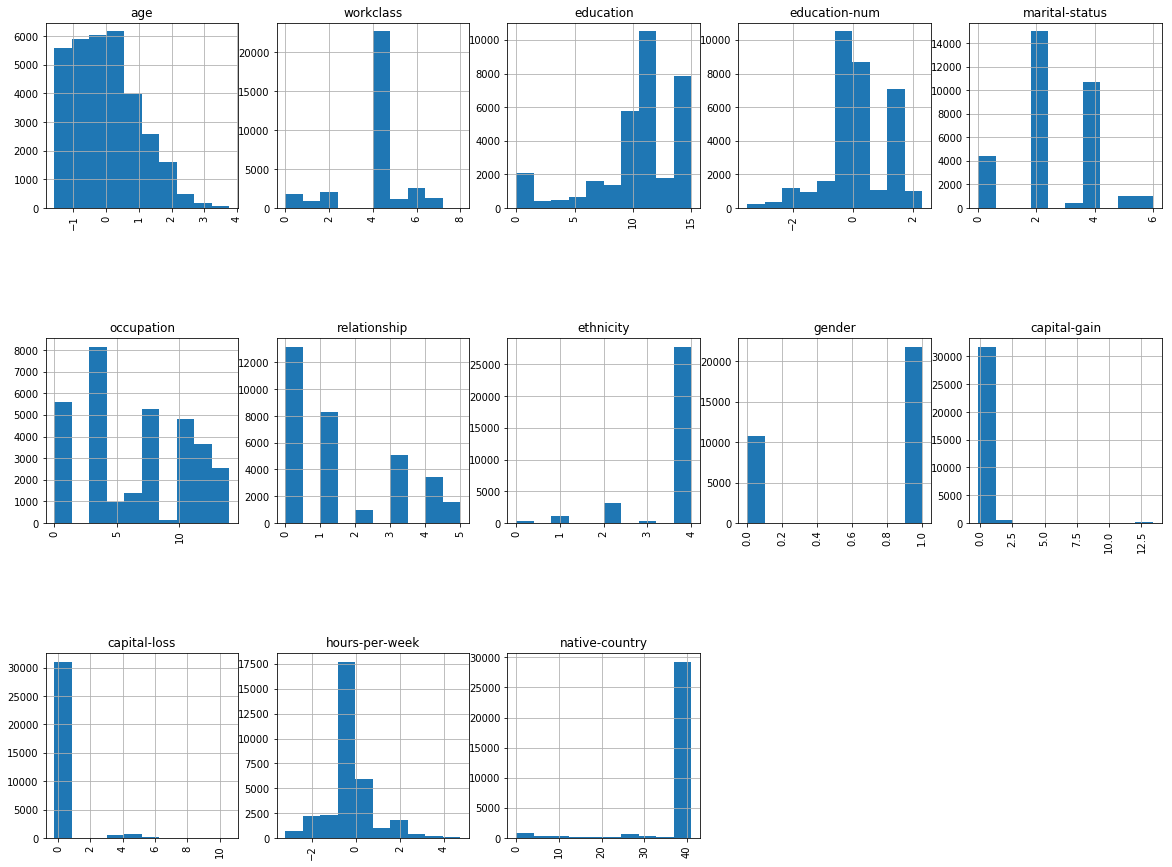

In [66]:
fig = plt.figure(figsize=(20,15))
cols = 5
rows = math.ceil(float(X.shape[1]) / cols)
for i, column in enumerate(X.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if X.dtypes[column] == np.object:
        X[column].value_counts().plot(kind="bar", axes=ax)
    else:
        X[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

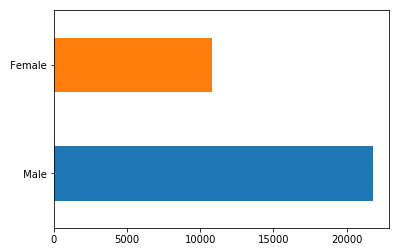

In [67]:
df["gender"].value_counts().plot.barh()

In [68]:
flds = ["gender", "age", "education-num", "capital-gain", 
                  "capital-loss", "hours-per-week"]


enc_summ = X_display[flds].groupby("gender", as_index=False).mean()
enc_summ

,gender,age,education-num,capital-gain,capital-loss,hours-per-week
0,Female,36.858230,10.035744,568.410547,61.187633,36.410361
1,Male,39.433547,10.102891,1329.370078,100.213309,42.428086


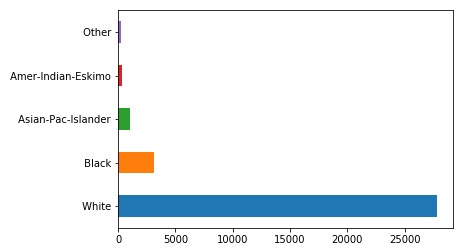

In [69]:
df["ethnicity"].value_counts().plot.barh()

In [70]:
import eli5
from eli5.sklearn import PermutationImportance

In [71]:
def keras_score(self, X, y, **kwargs):
    input_test = [X[:,i] for i in range(X.shape[1])]
    loss = self.evaluate(input_test, y)
    if type(loss) is list:
        # The first one is the error, the rest are metrics
        return -loss[0]
    return -loss

perm = PermutationImportance(model, random_state=1, scoring=keras_score).fit(X,y)

32561/32561 [==============================] - 0s 12us/step


In [72]:
eli5.show_weights(perm, feature_names = X.columns.tolist())

Weight,Feature
0.1467 ± 0.0019,capital-gain
0.0712 ± 0.0017,marital-status
0.0472 ± 0.0032,education-num
0.0421 ± 0.0017,age
0.0264 ± 0.0013,occupation
0.0230 ± 0.0015,hours-per-week
0.0196 ± 0.0016,relationship
0.0110 ± 0.0017,gender
0.0092 ± 0.0007,capital-loss
0.0032 ± 0.0010,native-country


In [73]:
eli5_fi = eli5.explain_weights_df(perm, feature_names = X.columns.tolist())
eli5_fi

,feature,weight,std
0,capital-gain,0.146681,0.000955
1,marital-status,0.071234,0.000832
2,education-num,0.047238,0.001592
3,age,0.042083,0.000837
4,occupation,0.026415,0.000642
5,hours-per-week,0.023021,0.000728
6,relationship,0.019604,0.000786
7,gender,0.010976,0.000847
8,capital-loss,0.009229,0.000365
9,native-country,0.003239,0.000478


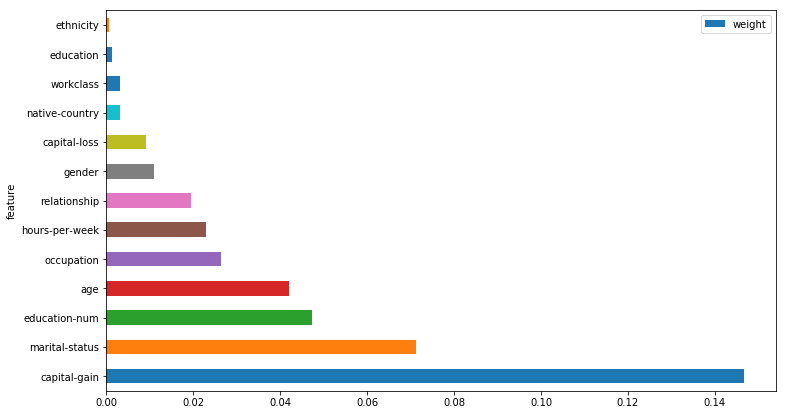

In [74]:
eli5_fi.plot("feature", "weight", "barh", figsize=(12,7))

# Sit down with our clients to understand these perspectives

/home/alejandro/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


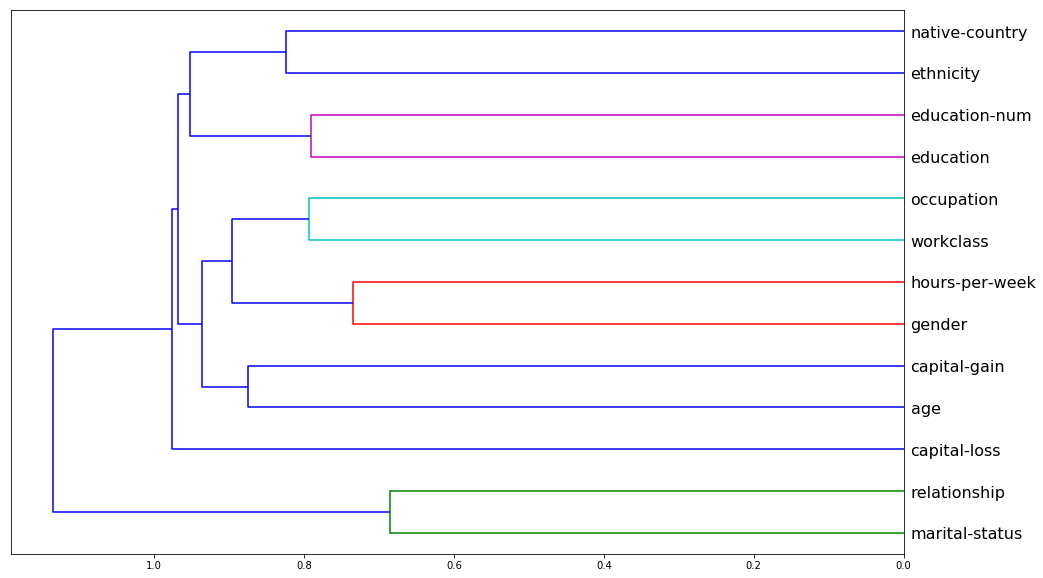

In [75]:
import scipy
from scipy.cluster import hierarchy as hc

corr = np.round(scipy.stats.spearmanr(X_analysis).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method="average")
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(
    z, labels=X_analysis.columns, orientation="left", leaf_font_size=16)
plt.show()

# Partial dependence

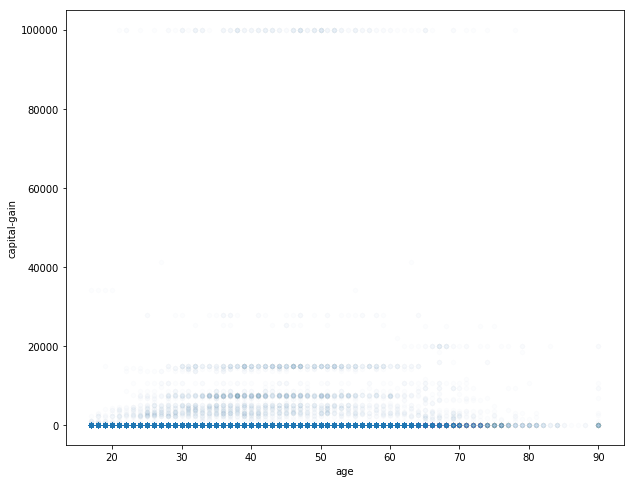

In [90]:
df_analysis.plot(
    "age", 
    "capital-gain",
    "scatter",
    alpha=0.01,
    figsize=(10,8))

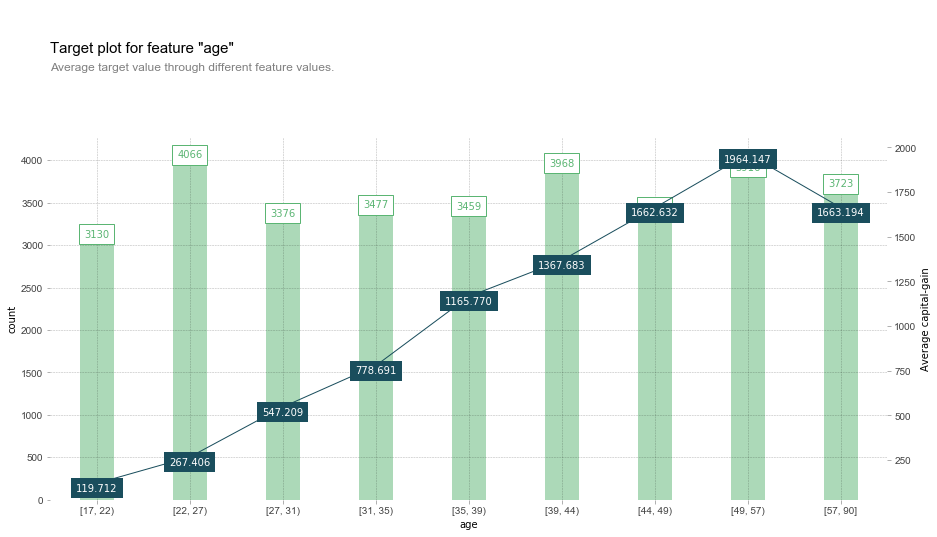

In [102]:
from pdpbox import pdp, get_dataset, info_plots

fig, axes, summary_df = info_plots.target_plot(
    df=df, feature="age", feature_name="age", target="capital-gain"
)

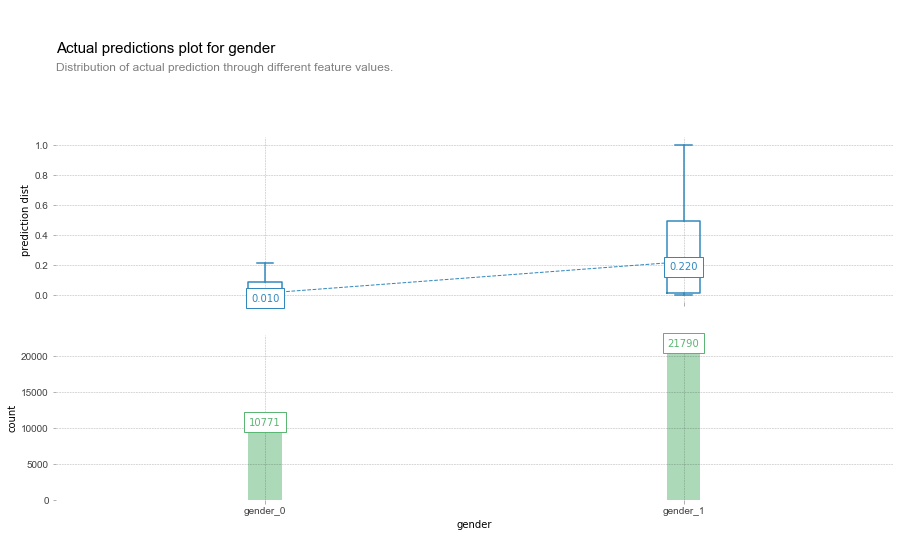

In [115]:
class ModelWrapper():
    def __init__(self, model):
        self.model = model
    
    def predict(self, X, **kwargs):
        return self.model.predict([X.iloc[:,i] for i in range(X.shape[1])])

mr = ModelWrapper(model)
    
fig, axes, summary_df = info_plots.actual_plot(
    model=mr, X=X, feature="gender", feature_name="gender", predict_kwds={})

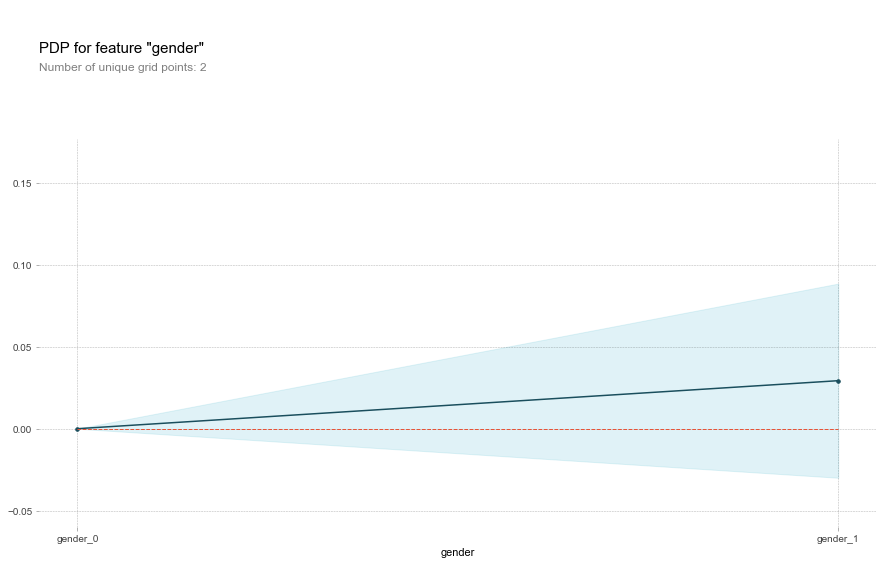

In [120]:
pdp_sex = pdp.pdp_isolate(
    model=mr, dataset=X, model_features=input_columns, feature='gender'
)

fig, axes = pdp.pdp_plot(pdp_sex, 'gender')